In [ ]:
pip install ta

In [ ]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout, BatchNormalization,RNN
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
import sklearn.metrics as metrics
import random
import keras
import keras.layers
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import keras
import ta
from sklearn.model_selection import train_test_split


In [ ]:
# pip install ta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

df=pd.read_csv("/content/drive/MyDrive/stock_price/merged_stock_data1.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
close_price_mid = []
close_price_25th = []
close_price_75th = []
for values in df['Close Price']:
  margin1 = round(random.uniform(-2,2),2)
  temp1 = values + ((margin1*values)/100)
  temp1 = round(temp1,2)
  close_price_mid.append(temp1)
  margin2 = round(random.uniform(-2,2),2)
  temp2 = values + ((margin2*values)/100)
  temp2 = round(temp2,2)
  close_price_25th.append(temp2)
  margin3 = round(random.uniform(-2,2),2)
  temp3 = values + ((margin3*values)/100)
  temp3 = round(temp3,2)
  close_price_75th.append(temp3)
df = df.assign(one_fourth_close_price = close_price_25th)
df = df.assign(mid_close_price = close_price_mid)
df = df.assign(three_fourth_close_price = close_price_75th)


In [ ]:
print(df)

In [ ]:
df.head(5)


In [ ]:
df.tail(5)

In [ ]:
print(df.isna().sum())
df = df.dropna()
print(df)
print(len(df))



In [ ]:


df_first = df
df_first['EMA_50'] = ta.trend.ema_indicator(df['Close Price'], window=50)
df_first['EMA_200'] = ta.trend.ema_indicator(df['Close Price'], window=200)
df_first['SMA_50'] = ta.trend.sma_indicator(df['Close Price'], window=50)
df_first['SMA_200'] = ta.trend.sma_indicator(df['Close Price'], window=200)
df_first['RSI'] = ta.momentum.rsi(df['Close Price'], window=14)
df_first['MACD'] = ta.trend.macd(df['Close Price'], window_slow=26, window_fast=12)
df_first['BB_upper'], df_first['BB_middle'], df_first['BB_lower'] = ta.volatility.bollinger_hband_indicator(df['Close Price']), ta.volatility.bollinger_mavg(df['Close Price']), ta.volatility.bollinger_lband_indicator(df['Close Price'])
df_first['%K'] = ta.momentum.stoch(high=df['High Price'],low=df['Low Price'], close=df['Close Price'], window=14)
df_first['%D'] = df_first['%K'].rolling(window=3).mean()
df_first['OBV'] = ta.volume.on_balance_volume(df['Close Price'], df['Close Price'].diff())
df_first['ATR'] = ta.volatility.average_true_range(high=df['High Price'],low=df['Low Price'], close=df['Close Price'], window=14)

In [ ]:
df_first

In [ ]:
print(df_first.isna().sum())

In [ ]:
df_first = df_first.dropna()

In [ ]:
print(len(df_first))

In [ ]:
rev_df = df_first # reverse here if data is from 2024 to 2014
rev_df

In [ ]:

print("Dataframe Shape:" , rev_df. shape)
print("Null Value Present: ", rev_df.isnull().values.any())

In [ ]:

rev_df['Close Price'].plot()


In [ ]:

#Selecting the Features
features = ['Open Price', 'High Price', 'Low Price', 'No.of Shares','one_fourth_close_price','mid_close_price','three_fourth_close_price','EMA_50','EMA_200','RSI','MACD','Close Price','%K','%D','OBV','ATR','BB_upper','BB_middle','BB_lower']


In [ ]:
#Scaling
output_var = pd.DataFrame(rev_df['Close Price'])
# un_normalized_var = pd.DataFrame(rev_df['Close Price'])
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(rev_df[features])
output_var = scaler.fit_transform(output_var)
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=rev_df.index)


In [ ]:
feature_transform.head()

In [ ]:
output_var

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(feature_transform, output_var, test_size=0.1,shuffle=False)
# tempa,tempb,tempc,un_normalized_y_test = train_test_split(feature_transform, un_normalized_var, test_size=0.1,shuffle=False)

print(X_test)
print(y_test)
# print(un_normalized_y_test)

In [ ]:

# 2. Sequence Creation
def create_sequences_X(data, seq_length):
    X = []
    for i in range(len(data) - seq_length ):
        X.append(data.iloc[i:i+seq_length])

    return np.array(X)
# def create_un_normalized_sequences_Y(data, seq_length):
#     Y = []
#     for i in range(seq_length,len(data)):
#         Y.append(data.iloc[i])

#     return np.array(Y)
def create_sequences_Y(data, seq_length):
    Y = []
    for i in range(seq_length,len(data)):
        Y.append(data[i])

    return np.array(Y)

seq_length = 50  # Choose an appropriate sequence length
X_train_seq= create_sequences_X(X_train, seq_length)

y_train_seq = create_sequences_Y(y_train, seq_length)
X_test_seq = create_sequences_X(X_test, seq_length)

y_test_seq = create_sequences_Y(y_test, seq_length)
# unnormal_y_test_seq = create_un_normalized_sequences_Y(un_normalized_y_test,seq_length)
print(len(X_test_seq))
print(len(y_test_seq))
# print(len(unnormal_y_test_seq))
print(X_test_seq)
print(y_test_seq)


# print(unnormal_y_test_seq)

In [ ]:

# 3. Model Building
model_with_peephole = Sequential([

    LSTM(units=450, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),activation='tanh', return_sequences=False),
    Dense(units=1)
])


multilayer_with_linear = Sequential([
    LSTM(units=250, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=200),  # Linear layer
    LSTM(units=250, activation='tanh', return_sequences=False),
    Dense(units=1)

])



two_layer_lstm = Sequential([
    LSTM(units=230, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(units=230, activation='tanh', return_sequences=False),
    Dense(units=1)

])

three_layer_lstm = Sequential([
    LSTM(units=220, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(units=180, activation='tanh', return_sequences=True),
    LSTM(units=180, activation='tanh', return_sequences=False),
    Dense(units=1)
])





# 4. Model Training
model_with_peephole.compile(loss='mean_squared_error', optimizer='adam')

multilayer_with_linear.compile(loss='mean_squared_error', optimizer='adam')

two_layer_lstm.compile(loss='mean_squared_error', optimizer='adam')


three_layer_lstm.compile(loss='mean_squared_error', optimizer='adam')






print(model_with_peephole.summary())

print(multilayer_with_linear.summary())

print(two_layer_lstm.summary())

print(three_layer_lstm.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 450)               846000    
                                                                 
 dense (Dense)               (None, 1)                 451       
                                                                 
Total params: 846451 (3.23 MB)
Trainable params: 846451 (3.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 250)           270000    
                                                                 
 dense_1 (Dense)             (None, 50, 200)           50200     
                                                           

In [ ]:
y_actual = scaler.inverse_transform(y_test_seq)

In [ ]:
def accuracy(y_test,y_pred):
  plt.plot(y_test, label='True Value')
  plt.plot(y_pred, label='LSTM Value')
  plt.title("Accuracy of Reliance stock")
  plt.xlabel('Time Scale')
  plt.ylabel('Scaled INR')
  plt.legend()
  plt.show()

  diff = y_pred - y_test
  var = ((abs(diff))/y_test)*100

  not_corr = [0,0,0,0,0,0,0,0,0,0]
  corr = [0,0,0,0,0,0,0,0,0,0]
  for i in range(0,10):
    for value in var :
      if value <= (i+1):
        corr[i] = corr[i]+1
      else:
        not_corr[i] = not_corr[i]+1
  for i in range(0,10):
    print("correctly predicted values in percentage range of ",i+1,"are: ",corr[i])
    print("Incorrectly predicted values in percentage range of ",i+1,"are: ",not_corr[i])
  accuracy = [0,0,0,0,0,0,0,0,0,0]
  for i in range(0,10):
    accuracy[i] = (corr[i]/(corr[i] + not_corr[i]))*100
    print("The accuracy of LSTM model in percentage range of ",i+1,"is :",accuracy[i])
  # y_pred=y_pred.flatten()
  # X_test=y_.flatten()
  mse = metrics.mean_squared_error(y_test,y_pred)
  mae = metrics.mean_absolute_error(y_test,y_pred)
  print(mse)
  print(mae)


In [ ]:

model_with_peephole.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,

                   )

In [ ]:

y_pred= model_with_peephole.predict(X_test_seq)
y_pred = scaler.inverse_transform(y_pred)




print(len(y_pred))
print(len(y_test_seq))
print(y_pred)
print(y_actual)



y_pred = y_pred.flatten()
y_test = y_actual.flatten()
accuracy(y_test,y_pred)

In [ ]:

multilayer_with_linear.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,

                   )

Epoch 1/50
56/56 [==============================] - 37s 575ms/step - loss: 0.0072 - val_loss: 0.0033
Epoch 2/50
56/56 [==============================] - 31s 560ms/step - loss: 4.9845e-05 - val_loss: 0.0014
Epoch 3/50
56/56 [==============================] - 34s 613ms/step - loss: 3.0584e-05 - val_loss: 8.5544e-04
Epoch 4/50
56/56 [==============================] - 30s 538ms/step - loss: 2.6747e-05 - val_loss: 9.4740e-04
Epoch 5/50
56/56 [==============================] - 31s 563ms/step - loss: 2.3411e-05 - val_loss: 7.5411e-04
Epoch 6/50
56/56 [==============================] - 31s 548ms/step - loss: 2.2250e-05 - val_loss: 7.5747e-04
Epoch 7/50
56/56 [==============================] - 30s 546ms/step - loss: 2.0522e-05 - val_loss: 8.9636e-04
Epoch 8/50
56/56 [==============================] - 30s 543ms/step - loss: 2.1552e-05 - val_loss: 0.0010
Epoch 9/50
56/56 [==============================] - 32s 565ms/step - loss: 2.1235e-05 - val_loss: 7.9407e-04
Epoch 10/50
56/56 [================

15/15 [==============================] - 3s 109ms/step
451
451
[[2330.5781]
 [2282.6455]
 [2255.057 ]
 [2236.7717]
 [2214.5906]
 [2209.6843]
 [2202.8623]
 [2234.3335]
 [2253.9329]
 [2237.3237]
 [2287.8828]
 [2305.3699]
 [2324.5745]
 [2340.8777]
 [2326.142 ]
 [2307.956 ]
 [2340.3167]
 [2332.2837]
 [2326.5032]
 [2355.3657]
 [2423.6694]
 [2409.4922]
 [2414.2925]
 [2393.004 ]
 [2421.6829]
 [2392.0996]
 [2350.7065]
 [2321.7957]
 [2301.4575]
 [2275.791 ]
 [2286.979 ]
 [2280.6707]
 [2297.333 ]
 [2270.0964]
 [2249.19  ]
 [2251.7673]
 [2247.4622]
 [2257.1794]
 [2284.0918]
 [2324.2227]
 [2245.96  ]
 [2203.3806]
 [2198.2998]
 [2183.341 ]
 [2164.848 ]
 [2157.1646]
 [2172.2932]
 [2175.7896]
 [2151.405 ]
 [2150.783 ]
 [2155.958 ]
 [2166.9475]
 [2177.697 ]
 [2226.601 ]
 [2245.1152]
 [2255.4   ]
 [2190.215 ]
 [2165.3108]
 [2161.3733]
 [2192.4473]
 [2281.2715]
 [2334.1711]
 [2349.31  ]
 [2362.0676]
 [2303.2246]
 [2254.259 ]
 [2260.046 ]
 [2278.1406]
 [2291.8708]
 [2310.8806]
 [2328.5254]
 [2338.9749]
 

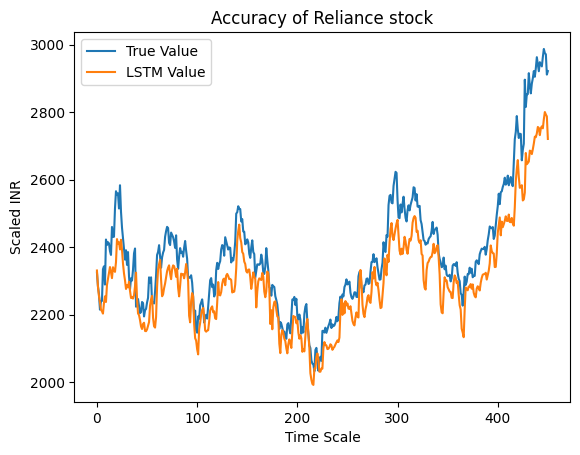

correctly predicted values in percentage range of  1 are:  43
Incorrectly predicted values in percentage range of  1 are:  408
correctly predicted values in percentage range of  2 are:  108
Incorrectly predicted values in percentage range of  2 are:  343
correctly predicted values in percentage range of  3 are:  211
Incorrectly predicted values in percentage range of  3 are:  240
correctly predicted values in percentage range of  4 are:  307
Incorrectly predicted values in percentage range of  4 are:  144
correctly predicted values in percentage range of  5 are:  371
Incorrectly predicted values in percentage range of  5 are:  80
correctly predicted values in percentage range of  6 are:  417
Incorrectly predicted values in percentage range of  6 are:  34
correctly predicted values in percentage range of  7 are:  435
Incorrectly predicted values in percentage range of  7 are:  16
correctly predicted values in percentage range of  8 are:  448
Incorrectly predicted values in percentage ra

In [ ]:

y_pred= multilayer_with_linear.predict(X_test_seq)
y_pred = scaler.inverse_transform(y_pred)





print(len(y_pred))
print(len(y_test_seq))
print(y_pred)
print(y_actual)



y_pred = y_pred.flatten()
y_test = y_actual.flatten()
accuracy(y_test,y_pred)

In [ ]:

two_layer_lstm.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,

                   )

Epoch 1/50
56/56 [==============================] - 34s 515ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 2/50
56/56 [==============================] - 29s 523ms/step - loss: 7.1129e-05 - val_loss: 0.0013
Epoch 3/50
56/56 [==============================] - 29s 527ms/step - loss: 3.4444e-05 - val_loss: 7.5245e-04
Epoch 4/50
56/56 [==============================] - 29s 525ms/step - loss: 2.7544e-05 - val_loss: 6.0409e-04
Epoch 5/50
56/56 [==============================] - 30s 533ms/step - loss: 2.4378e-05 - val_loss: 5.1912e-04
Epoch 6/50
56/56 [==============================] - 28s 508ms/step - loss: 2.2682e-05 - val_loss: 5.1956e-04
Epoch 7/50
56/56 [==============================] - 28s 511ms/step - loss: 2.0659e-05 - val_loss: 5.8357e-04
Epoch 8/50
56/56 [==============================] - 29s 512ms/step - loss: 2.1363e-05 - val_loss: 9.6559e-04
Epoch 9/50
56/56 [==============================] - 28s 508ms/step - loss: 1.9557e-05 - val_loss: 5.9495e-04
Epoch 10/50
56/56 [============

15/15 [==============================] - 3s 130ms/step
451
451
[[2317.7131]
 [2275.1455]
 [2247.8164]
 [2229.1877]
 [2206.838 ]
 [2199.2974]
 [2189.6746]
 [2213.1855]
 [2228.4985]
 [2213.3208]
 [2254.5088]
 [2271.8523]
 [2288.3237]
 [2304.2969]
 [2294.9907]
 [2280.428 ]
 [2308.3428]
 [2307.3718]
 [2301.575 ]
 [2327.3708]
 [2387.355 ]
 [2377.5625]
 [2382.598 ]
 [2366.6362]
 [2390.4607]
 [2368.8955]
 [2332.1472]
 [2305.7126]
 [2285.316 ]
 [2261.5217]
 [2268.3826]
 [2261.9307]
 [2274.2786]
 [2250.288 ]
 [2229.9258]
 [2229.106 ]
 [2224.3518]
 [2229.9355]
 [2252.3503]
 [2285.4863]
 [2228.207 ]
 [2187.549 ]
 [2178.2356]
 [2163.9124]
 [2145.7188]
 [2136.9329]
 [2147.743 ]
 [2149.5752]
 [2128.6387]
 [2126.1438]
 [2129.8171]
 [2139.317 ]
 [2149.0073]
 [2192.8203]
 [2211.5732]
 [2221.6968]
 [2169.0056]
 [2144.8354]
 [2140.6223]
 [2167.4312]
 [2245.196 ]
 [2294.3718]
 [2309.4607]
 [2320.7393]
 [2271.785 ]
 [2228.5742]
 [2231.566 ]
 [2249.3792]
 [2264.073 ]
 [2284.5024]
 [2302.0627]
 [2314.116 ]
 

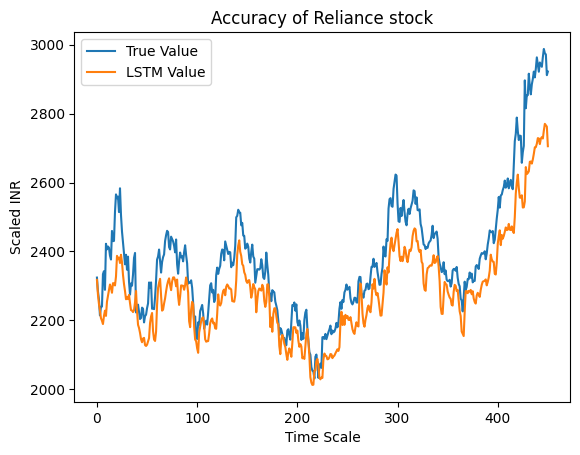

correctly predicted values in percentage range of  1 are:  33
Incorrectly predicted values in percentage range of  1 are:  418
correctly predicted values in percentage range of  2 are:  76
Incorrectly predicted values in percentage range of  2 are:  375
correctly predicted values in percentage range of  3 are:  157
Incorrectly predicted values in percentage range of  3 are:  294
correctly predicted values in percentage range of  4 are:  257
Incorrectly predicted values in percentage range of  4 are:  194
correctly predicted values in percentage range of  5 are:  339
Incorrectly predicted values in percentage range of  5 are:  112
correctly predicted values in percentage range of  6 are:  392
Incorrectly predicted values in percentage range of  6 are:  59
correctly predicted values in percentage range of  7 are:  423
Incorrectly predicted values in percentage range of  7 are:  28
correctly predicted values in percentage range of  8 are:  439
Incorrectly predicted values in percentage ra

In [ ]:

y_pred= two_layer_lstm.predict(X_test_seq)
y_pred = scaler.inverse_transform(y_pred)





print(len(y_pred))
print(len(y_test_seq))
print(y_pred)
print(y_actual)



y_pred = y_pred.flatten()
y_test = y_actual.flatten()
accuracy(y_test,y_pred)

In [ ]:

three_layer_lstm.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,

                   )

Epoch 1/50
56/56 [==============================] - 41s 629ms/step - loss: 0.0040 - val_loss: 0.0076
Epoch 2/50
56/56 [==============================] - 42s 744ms/step - loss: 6.3334e-05 - val_loss: 0.0024
Epoch 3/50
56/56 [==============================] - 35s 615ms/step - loss: 4.5469e-05 - val_loss: 0.0029
Epoch 4/50
14/56 [======>.......................] - ETA: 20s - loss: 4.3260e-05

In [ ]:

y_pred= three_layer_lstm.predict(X_test_seq)
y_pred = scaler.inverse_transform(y_pred)





print(len(y_pred))
print(len(y_test_seq))
print(y_pred)
print(y_actual)



y_pred = y_pred.flatten()
y_test = y_actual.flatten()
accuracy(y_test,y_pred)